# Becoming backprop ninja

This lecture is more of a workbook style lecture it seems. I am going to first do the exercises myself and then see how Andrej implements it. The first few cells are the same as before where you do your standard imports and then prepare your data

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [2]:
with open('names.txt') as f:
    names = f.readlines()
    names = [name.strip('\n') for name in names]

In [3]:
# alternate implementation, used by Andrej
names = open('names.txt', 'r').read().splitlines()

In [4]:
# prepare the vocab
tokens = ['.'] + sorted(set(''.join(names)))
stoi = {}
itos = {}
for i, token in enumerate(tokens):
    stoi[token] = i
    itos[i] = token

In [5]:
def buildDataset(names):
    X, Y = [], []
    for name in names:
        chars = [0] * 3
        for x in name + '.':
            xi = stoi[x]
            X.append(chars)
            Y.append(xi)
            chars = chars[1:] + [xi]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return (X, Y)

In [6]:
import random
random.shuffle(names)

samples = len(names)

train = 0.8
val = 0.9
test = 1.0

Xtr, Ytr = buildDataset(names[:int(train*samples)])
Xval, Yval = buildDataset(names[int(train*samples):int(val*samples)])
Xtest, Ytest = buildDataset(names[int(val*samples):])

In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weights = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.randn((fan_out,)) * 0.1 if bias else None
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

In [10]:
max_iterations = 20000
vocab_size = len(stoi)
context_length = 3
embedding_dim = 10
hidden_dim = 200
minibatch_size = 32
lr = 0.1

C = torch.randn((vocab_size, embedding_dim))
layers = [
    Linear(embedding_dim*context_length, hidden_dim), Tanh(),
    Linear(                  hidden_dim, vocab_size)
]

parameters = [C] + [p for layer in layers if isinstance(layer, Linear) for p in layer.parameters()]
for p in parameters:
    p.requires_grad_()

print(sum([p.nelement() for p in parameters]))

11897


In [17]:
for step in range(max_iterations + 1):
    # minibatch
    minibatch = torch.randint(Xtr.shape[0], (minibatch_size,))

    # forward pass
    emb = C[Xtr[minibatch]]
    embcat = emb.view(-1, embedding_dim * context_length)
    x = embcat
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Ytr[minibatch])
    
    # calculate gradient
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update values
    for p in parameters:
        p.data -= lr * p.grad
    
    # print progress
    if step % 2000 == 0:
        print(f'{step}/{max_iterations} loss = {loss.item()}')

0/20000 loss = 2.6045684814453125
2000/20000 loss = 2.095168352127075
4000/20000 loss = 1.7923805713653564
6000/20000 loss = 2.142599582672119
8000/20000 loss = 1.9210169315338135
10000/20000 loss = 2.3190653324127197
12000/20000 loss = 1.9645098447799683
14000/20000 loss = 2.592478036880493
16000/20000 loss = 2.202781915664673
18000/20000 loss = 2.5616817474365234
20000/20000 loss = 2.426074266433716


So far we were just recreating what we did in the previous lectures. Now we "chunkate" the code and write it in a way where we don't use a lot of internal functions of PyTorch in order to implement backprop on our own

In [51]:
max_iterations = 20000
vocab_size = len(stoi)
context_length = 3
embedding_dim = 10
hidden_dim = 200
minibatch_size = 32
lr = 0.1
epsilon = 1e-5

C = torch.randn((vocab_size, embedding_dim))
# Linear layer 1
W1 = torch.randn((context_length * embedding_dim, hidden_dim)) * 0.1
b1 = torch.randn((hidden_dim,)) * 0.01
# Batch norm tensors
gamma = torch.ones((hidden_dim,))
beta = torch.zeros((hidden_dim,))
# Linear layer 2
W2 = torch.randn((hidden_dim, vocab_size)) * 0.1
b2 = torch.randn((vocab_size,)) * 0.01

parameters = [C, W1, b1, gamma, beta, W2, b2]
for p in parameters:
    p.requires_grad_()

print(sum([p.nelement() for p in parameters]))

12297


In [52]:
for step in range(max_iterations + 1):
    # minibatch
    minibatch = torch.randint(Xtr.shape[0], (minibatch_size,))

    # ----- forward pass -----
    # embedding and concatenating
    emb = C[Xtr[minibatch]]
    embcat = emb.view(-1, embedding_dim * context_length)
    # Linear layer 1
    h1preact = embcat @ W1 + b1
    # Batch Norm
    h1mean = h1preact.mean(0, keepdims=True)
    h1var = h1preact.var(0, keepdims=True)
    h1shifted = h1preact - h1mean
    h1scalefactor = torch.sqrt(h1var + epsilon)
    xhat = h1shifted / h1scalefactor
    yhat = gamma * xhat + beta
    # Activation
    h1 = torch.tanh(yhat)
    # Linear layer 2 
    h2 = h1 @ W2 + b2
    # Calculate the loss function
    counts = h2.exp()
    probs = counts / counts.sum(1, keepdims=True)
    logprobs = -probs.log()
    predprob = logprobs[torch.arange(minibatch_size), Ytr[minibatch]]
    loss = predprob.mean()
    
    # calculate gradient
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update values
    for p in parameters:
        p.data -= lr * p.grad
    
    # print progress
    if step % 2000 == 0:
        print(f'{step}/{max_iterations} loss = {loss.item()}')

0/20000 loss = 3.775161027908325
2000/20000 loss = 2.462073802947998
4000/20000 loss = 2.5500526428222656
6000/20000 loss = 2.0544486045837402
8000/20000 loss = 2.1829376220703125
10000/20000 loss = 2.486475706100464
12000/20000 loss = 2.3895978927612305
14000/20000 loss = 2.130673408508301
16000/20000 loss = 2.0279457569122314
18000/20000 loss = 2.4456534385681152
20000/20000 loss = 2.4373044967651367


We now have something that works as intended. This is good. Now we will just import the code that Andrej wrote so that we are in unision with the lecture

In [75]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(names):  
  X, Y = [], []
  
  for w in names:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr,  Ytr  = build_dataset(names[:n1])     # 80%
Xdev, Ydev = build_dataset(names[n1:n2])   # 10%
Xte,  Yte  = build_dataset(names[n2:])     # 10%

torch.Size([182479, 3]) torch.Size([182479])
torch.Size([22760, 3]) torch.Size([22760])
torch.Size([22907, 3]) torch.Size([22907])


In [248]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad, atol=1e-7)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [76]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [77]:
Yb.shape

torch.Size([32])

In [270]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP
block_size = 3

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = None # TODO. my solution is 3 lines
# -----------------

#cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9
loss.backward()
loss

4137


tensor(3.4203, grad_fn=<NegBackward0>)

In [154]:
counts_sum_inv.shape

torch.Size([32, 1])

In [126]:
logits.shape, logit_maxes.shape, norm_logits.shape

(torch.Size([32, 27]), torch.Size([32, 1]), torch.Size([32, 27]))

In [271]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------

# Older implementations will be in comments in case the implementation needs to be changed

dlogprobs = torch.zeros_like(logprobs)
# dlogprobs = torch.zeros((logprobs.shape))
dlogprobs[range(batch_size), Yb] = - 1/batch_size
# for sample, y in zip(range(batch_size), Yb):
#    dlogprobs[sample, y] = - 1/batch_size
# The for loop is not needed in torch

dprobs = dlogprobs * (1/probs)
# dprobs = torch.zeros_like(probs)
# dprobs[range(batch_size), Yb] = dlogprobs[range(batch_size), Yb] * (1/probs[range(batch_size), Yb])

dcounts_sum_inv = (dprobs * counts).sum(1, keepdims = True)

dcounts = counts_sum_inv * dprobs
dcounts_sum = -1 / (torch.square(counts_sum)) * dcounts_sum_inv
dcounts += dcounts_sum

dnorm_logits = norm_logits.exp() * dcounts
dlogit_maxes = -dnorm_logits.sum(1, keepdims=True)

dlogits = dnorm_logits.clone()
dlogits -= dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = dh * (torch.ones_like(h) - (h)**2)
dbngain = (dhpreact * bnraw).sum(0, keepdims=True)
dbnbias = dhpreact.sum(0, keepdims = True)
dbnraw = dhpreact * bngain

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims = True)

dbnvar = dbnvar_inv * ((-(bnvar + epsilon)**-1.5)/2)

dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar

dbndiff = bnvar_inv * dbnraw
dbndiff += 2 * bndiff * dbndiff2

dbnmeani = -dbndiff.sum(0, keepdims = True)
dhprebn = dbndiff.clone()
dhprebn += 1/n * torch.ones_like(hprebn) * dbnmeani

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdims=True)

demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i,j]
        dC[ix] += demb[i,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-08
h               | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
W2              | exact: False | approximate: True  | maxdiff: 2.60770320892334e-08
b2              | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-08
hpreact         | exact: False | approximate: True  | maxdiff: 7.916241884231567e-09
bngain          | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09
bnbias          | ex

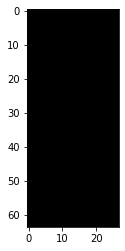

In [232]:
plt.imshow((W2.grad - dW2)>1e-7, cmap = 'gray')

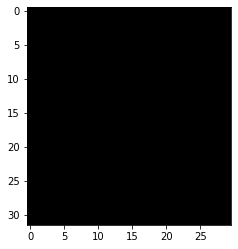

In [247]:
plt.imshow((embcat.grad - dembcat)>1e-7, cmap = 'gray')

In [265]:
C.shape, Xb.shape, emb.shape

(torch.Size([27, 10]), torch.Size([32, 3]), torch.Size([32, 3, 10]))

In [272]:
logits.shape

torch.Size([32, 27])

In [279]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = None # TODO. my solution is 3 lines
# -----------------

dlogits = 1/n * F.softmax(logits, dim=1)
dlogits[range(len(Yb)),Yb] -= 1/n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

3.4203014373779297 diff: 2.384185791015625e-07
logits          | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09


In [274]:
len(Yb)

32

In [281]:
hpreact.shape

torch.Size([32, 64])

I am going to play around a bit to understand Bessel's correction

In [311]:
num_samples = 10000
samples = torch.randn((num_samples,))
samples.mean(), samples.var()

(tensor(0.0241), tensor(1.0088))

In [320]:
biasedvars = []
unbiasedvars = []
for _ in range(10000):
    smallSampleix = torch.randint(num_samples, (64,))
    smallSample = samples[smallSampleix]
    biasedvars.append(smallSample.var(unbiased=False))
    unbiasedvars.append(smallSample.var(unbiased=True))

In [321]:
sum(biasedvars)/10000

tensor(0.9921)

In [322]:
sum(unbiasedvars)/10000

tensor(1.0078)

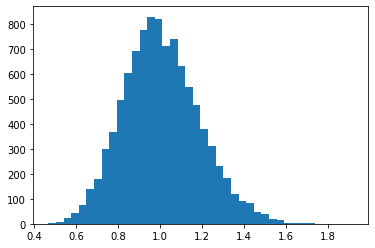

In [323]:
plt.hist(unbiasedvars,bins=40);

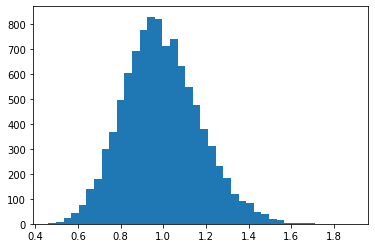

In [324]:
plt.hist(biasedvars,bins=40);

In [326]:
hprebn.shape, hpreact.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [329]:
bnbias.shape

torch.Size([1, 64])

In [330]:
dhpreact

tensor([[-7.1213e-04, -3.8987e-05, -2.8595e-03,  ...,  1.7372e-03,
         -6.0090e-04, -1.4034e-04],
        [-6.1274e-04,  9.5163e-04,  1.4944e-03,  ...,  1.0453e-03,
         -4.9984e-03,  5.1599e-04],
        [ 4.7964e-04,  2.1950e-03,  1.2118e-03,  ..., -9.3275e-04,
         -2.1857e-03,  1.5204e-03],
        ...,
        [-4.3875e-04,  3.1108e-04,  2.8374e-03,  ..., -1.6436e-03,
          6.5802e-04,  1.1402e-03],
        [ 6.6444e-04,  5.3180e-03,  2.6926e-04,  ...,  2.7807e-04,
          9.5291e-05, -3.8349e-05],
        [ 4.2304e-03, -2.7769e-04,  1.4421e-03,  ..., -1.4400e-03,
          5.7057e-04, -4.0913e-04]], grad_fn=<MulBackward0>)